In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline 

#import plotly
#plotly.tools.set_credentials_file(username='opotowsky', api_key='FcAjopvgrck2vVsvcalR')


### Notes from viz lectures

### Simplification
* Figure out consolidation schemes--ratios might be useful for rxtr params
* Exclude or dim unimportant data

### Headings for training set viz
* Goal for i.i.d. training set accomplished / not accomplished
* Certain locations in training set space difficult to predict OR error higher in certain locations in training set space
* Natural uranium not reliably predicted by any algorithm
* Complex models predict x parameters better than simple models (or vice versa)

In [2]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }
# set params
# save as .mplstyle file and import with: plt.style.use('file')
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.color'] = 'r'

# colors for seaborn
dark = ["#8c510a", "#01665e", "#762a83"]
med = ["#d8b365", "#5ab4ac", "#af8dc3"]


## Predictions

In [4]:
rxtr = pd.read_csv('../results/28march2018/sfcompo_fissact_reactor_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# MWd/MTU
burn = pd.read_csv('../results/28march2018/sfcompo_fissact_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# %u235
enri = pd.read_csv('../results/28march2018/sfcompo_fissact_enrichment_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# days
cool = pd.read_csv('../results/28march2018/sfcompo_fissact_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})

rxtr.columns

Index(['Instance', 'Ridge', 'SVR', 'TrueY', 'kNN'], dtype='object')

## Scores

In [7]:
r_scr = pd.read_csv('../results/3april2018/sfcompo_fissactreactor_scores.csv').rename(columns = {'Unnamed: 0':'CV_fold'})
# MWd/MTU
b_scr = pd.read_csv('../results/3april2018/sfcompo_fissactburnup_scores.csv').rename(columns = {'Unnamed: 0':'CV_fold'})
# %u235
e_scr = pd.read_csv('../results/3april2018/sfcompo_fissactenrichment_scores.csv').rename(columns = {'Unnamed: 0':'CV_fold'})
# days
c_scr = pd.read_csv('../results/3april2018/sfcompo_fissactcooling_scores.csv').rename(columns = {'Unnamed: 0':'CV_fold'})
c_scr.sample()

,CV_fold,fit_time,score_time,test_explained_variance,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2,test_neg_rmse,algorithm
6,6,0.102918,0.422362,0.973167,-46.557961,-18366.490159,0.972135,-135.523024,knn


### Errors

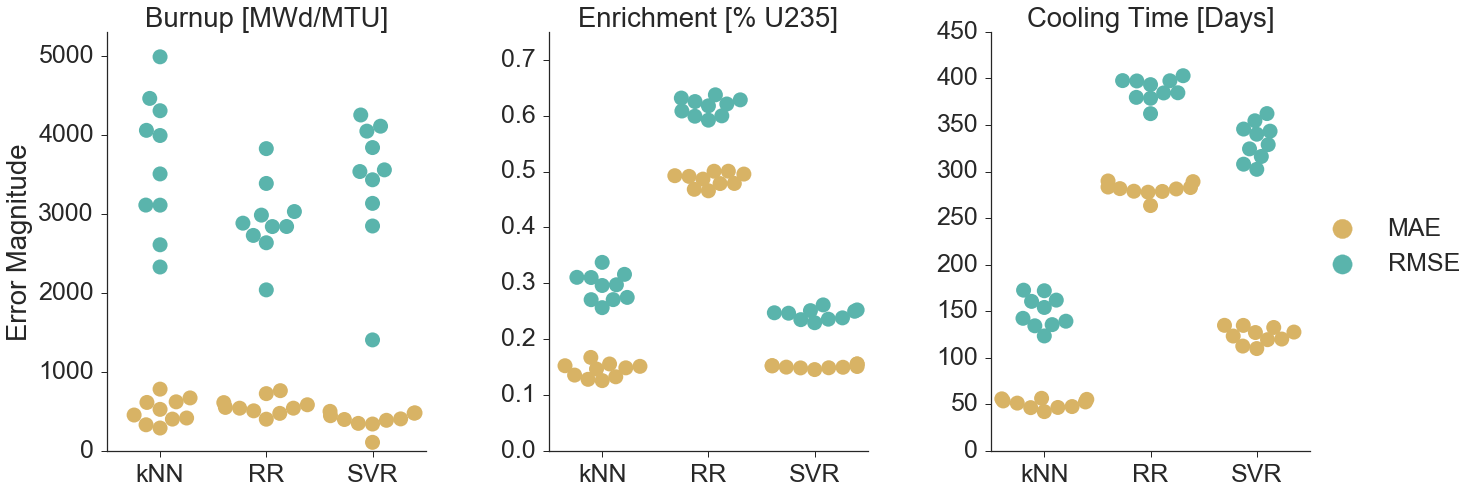

In [6]:
plt.clf()
sns.set(style="ticks", font_scale=2.5)
b = b_scr.loc[:, ['algorithm', 'test_neg_mean_absolute_error', 'test_neg_rmse']]
e = e_scr.loc[:, ['algorithm', 'test_neg_mean_absolute_error', 'test_neg_rmse']]
c = c_scr.loc[:, ['algorithm', 'test_neg_mean_absolute_error', 'test_neg_rmse']]
b['Parameter'] = 'Burnup [MWd/MTU]'
e['Parameter'] = 'Enrichment [% U235]'
c['Parameter'] = 'Cooling Time [Days]'

err = pd.DataFrame()
err = pd.concat([b, e, c])
err['MAE'] = -1 * err['test_neg_mean_absolute_error']
err['RMSE'] = -1 * err['test_neg_rmse']

err = err.melt(id_vars = ['algorithm', 'Parameter'], 
               value_vars = ['MAE', 'RMSE'], 
               value_name='Error Magnitude', var_name='Error')

mer = sns.factorplot(x="algorithm", y='Error Magnitude',
                     hue='Error', col="Parameter", ci=95,
                     sharey=False, s=15, legend=False,
                     palette=sns.color_palette(med), 
                     data=err, kind="swarm", size=8, aspect=.8)

(mer.set_axis_labels("", "Error Magnitude")
    .set_xticklabels(["kNN", "RR", "SVR"])
    .set_titles("{col_name}")
    .add_legend(markerscale=2.5))
mer.axes[0,0].set_ylim(0, 5300)
mer.axes[0,1].set_ylim(0, 0.75)
mer.axes[0,2].set_ylim(0, 450)
mer.savefig('error.png', bbox_inches='tight', transparent=True)

### Variance

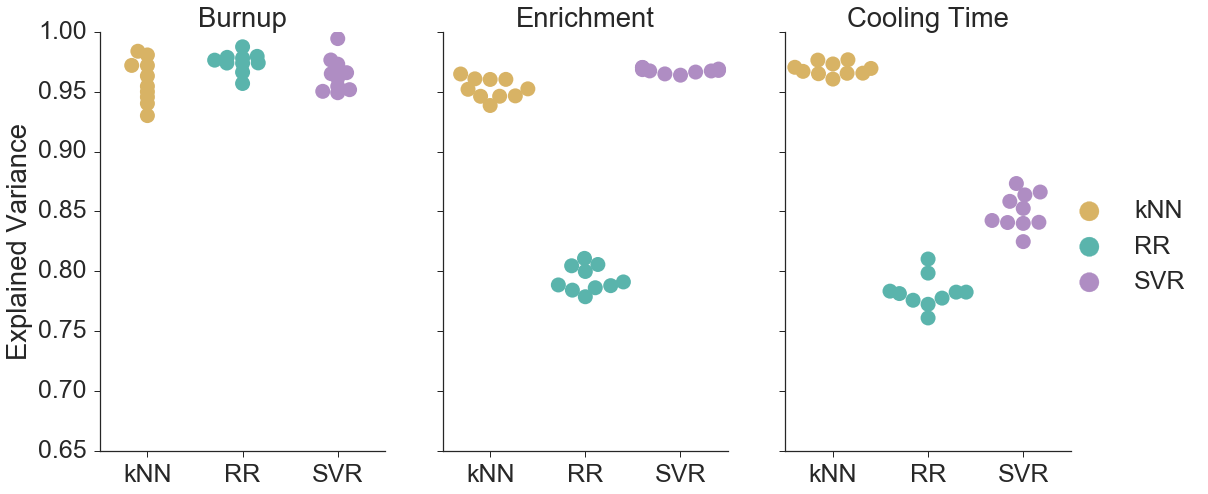

In [7]:
plt.clf()
sns.set(style="ticks", font_scale=2.5)
b = b_scr.loc[:, ['algorithm', 'test_explained_variance']]
e = e_scr.loc[:, ['algorithm', 'test_explained_variance']]
c = c_scr.loc[:, ['algorithm', 'test_explained_variance']]
b['Parameter'] = 'Burnup'
e['Parameter'] = 'Enrichment'
c['Parameter'] = 'Cooling Time'
scr = pd.DataFrame()
scr = pd.concat([b, e, c])

var = sns.factorplot(x="algorithm", y="test_explained_variance",
                     hue="algorithm", col="Parameter",
                     s=15, legend=False, ci=95, 
                     palette=sns.color_palette(med), 
                     data=scr, kind="swarm", size=8, aspect=.65)

(var.set_axis_labels("", "Explained Variance")
    .set_xticklabels(["kNN", "RR", "SVR"])
    .set_titles("{col_name}")
    .set(ylim=(0.65, 1.0))
    .add_legend(markerscale=2.5))
new_labels = ['kNN', 'RR', 'SVR']
for t, l in zip(var._legend.texts, new_labels): t.set_text(l)
var.savefig('variance.png', bbox_inches='tight', transparent=True)

In [8]:
trainXY = pd.read_pickle("sfcompo_pickles/not-scaled_trainset_nucs_fissact_8dec.pkl")
#x = len(trainXY.columns)-3
#dfX = trainXY.iloc[:, 0:x]
#dfY_e = trainXY.iloc[:, x+1]
#dfY_b = trainXY.iloc[:, x+2]
trainXY.columns

Index(['Burnup', 'CoolingTime', 'Enrichment', 'ReactorType', 'ba138', 'ce140',
       'ce142', 'ce144', 'cs133', 'cs135', 'cs137', 'la139', 'mo100', 'mo95',
       'mo97', 'mo98', 'nd143', 'nd144', 'nd145', 'nd146', 'pd104', 'pd105',
       'pd106', 'pr141', 'pu239', 'pu240', 'pu241', 'pu242', 'rb87', 'rh103',
       'ru101', 'ru102', 'ru104', 'sr88', 'sr90', 'tc99', 'total', 'u234',
       'u235', 'u236', 'u238', 'xe131', 'xe132', 'xe134', 'xe136', 'y89',
       'zr91', 'zr92', 'zr93', 'zr94', 'zr96'],
      dtype='object')

In [9]:
# nucs messed up somehow and labels are at beginning
x = len(trainXY.columns)
dfY_b = trainXY.iloc[:, 0]//1000
dfY_c = trainXY.iloc[:, 1]//30
dfY_e = trainXY.iloc[:, 2]
dfY_r = trainXY.iloc[:, 3]
dfX = trainXY.iloc[:, 4:x]

burn_name = 'Burnup [GWd/MTU]'
cool_name = 'Cooling Time [Months]'
enr_name = 'Enrichment [% U235]'
rxtr_name = 'Reactor Type'
trainXY[burn_name] = trainXY['Burnup']//1000
trainXY[cool_name] = trainXY['CoolingTime']//30
trainXY[enr_name] = trainXY['Enrichment']
trainXY[rxtr_name] = trainXY['ReactorType']

## Training Set Space Visualized
### Goal for i.i.d. training set accomplished / not accomplished

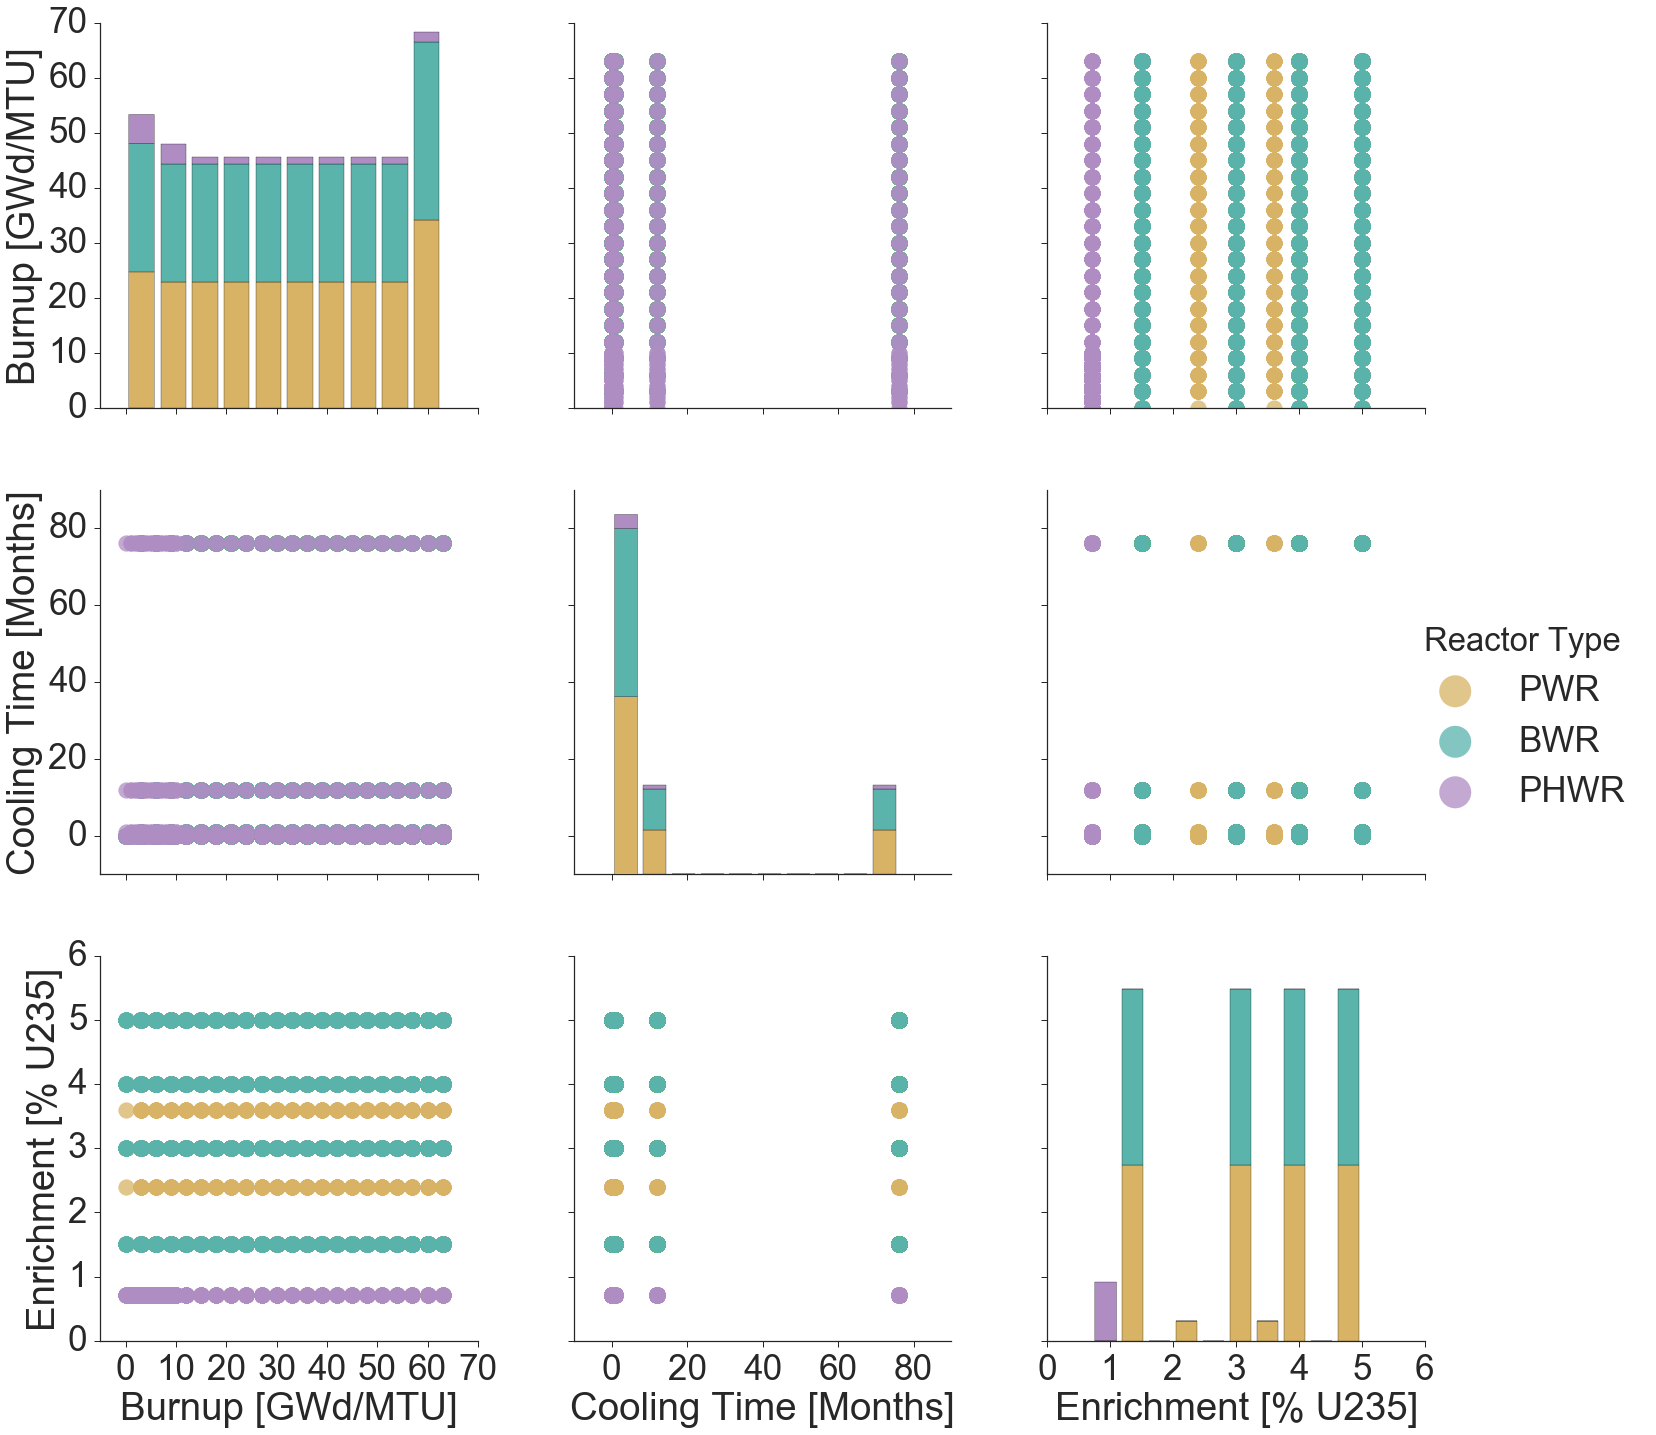

In [10]:
plt.clf()
train = trainXY[[burn_name, cool_name, enr_name, rxtr_name]]
g = sns.set(style="ticks", font_scale=3.5)
g = sns.PairGrid(train, hue=rxtr_name, palette=sns.color_palette(med), 
                 diag_sharey=False, size=7)
g.map_diag(plt.hist, edgecolor="k")
g.map_offdiag(plt.scatter, s=250, alpha=0.75)
g.axes[0,0].set_ylim(0, 70)
g.axes[2,0].set_xlim(-5, 70)
g.add_legend(markerscale=2)
new_labels = ['PWR', 'BWR', 'PHWR']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.savefig('train_set.png', bbox_inches='tight', transparent=True)

## Predictions

In [28]:
burn.sample(3)

,Instance,Ridge,SVR,TrueY,kNN
5658,2.165e+03,36267.652685,36007.286166,36000,36000.0
2420,2.000e+02.1,5931.586862,6031.720495,6000,6000.0
87,1.530e+03,45143.705750,44982.965088,45000,45000.0


In [29]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

pred_df = rxtr
pred_df = pred_df.melt(id_vars = 'TrueY', 
                 value_vars = ['SVR', 'kNN', 'Ridge'], 
                 value_name='Predicted Value', var_name='Algorithm')
print(pred_df)
pred = sns.FacetGrid(data=pred_df, hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_title("Reactor Type")
     .add_legend(markerscale=2))
#pred.axes[0,0].set_ylim(-5, 70)
#pred.axes[0,0].set_xlim(-5, 70)
#plt.plot([-5, -5], [65, 65], 'k-', linewidth=2)

pred.savefig('tset_rxtr_predictions.png', bbox_inches='tight', transparent=True)

      TrueY Algorithm Predicted Value
0       pwr       SVR             bwr
1       pwr       SVR             bwr
2       pwr       SVR             bwr
3       pwr       SVR             bwr
4       pwr       SVR             bwr
5       pwr       SVR             bwr
6       pwr       SVR             bwr
7       pwr       SVR             pwr
8       pwr       SVR             pwr
9       pwr       SVR             bwr
10      pwr       SVR             bwr
11      pwr       SVR             bwr
12      pwr       SVR             pwr
13      pwr       SVR             pwr
14      pwr       SVR             pwr
15      pwr       SVR             pwr
16      pwr       SVR             pwr
17      pwr       SVR             pwr
18      pwr       SVR             pwr
19      pwr       SVR             pwr
20      pwr       SVR             pwr
21      pwr       SVR             pwr
22      pwr       SVR             pwr
23      pwr       SVR             pwr
24      pwr       SVR             pwr
25      pwr 

ValueError: could not convert string to float: 'phwr'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f039bf6bae8> (for post_execute):


ValueError: could not convert string to float: 'phwr'

ValueError: could not convert string to float: 'phwr'

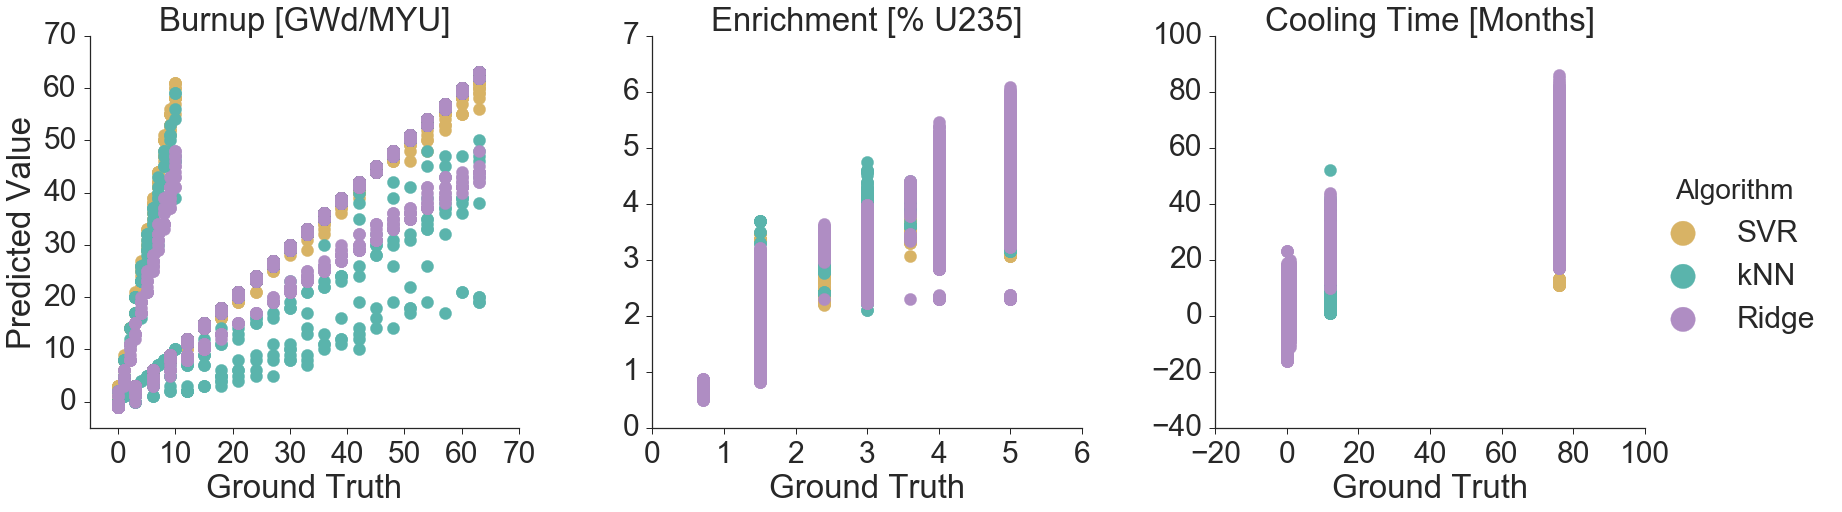

In [30]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

burn = pd.read_csv('results/28march2018/sfcompo_fissact_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
cool = pd.read_csv('results/28march2018/sfcompo_fissact_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
burn = burn.loc[:, ['SVR', 'TrueY', 'kNN', 'Ridge']]//1000
cool = cool.loc[:, ['SVR', 'TrueY', 'kNN', 'Ridge']]//30
burn['Parameter'] = 'Burnup [GWd/MYU]'
enri['Parameter'] = 'Enrichment [% U235]'
cool['Parameter'] = 'Cooling Time [Months]'

pred_df = pd.DataFrame()
pred_df = pd.concat([burn, enri, cool])
pred_df = pred_df.melt(id_vars = ['TrueY', 'Parameter'], 
                 value_vars = ['SVR', 'kNN', 'Ridge'], 
                 value_name='Predicted Value', var_name='Algorithm')
pred = sns.FacetGrid(data=pred_df, col="Parameter",
                     hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_titles("{col_name}")
     .add_legend(markerscale=2))
pred.axes[0,0].set_ylim(-5, 70)
pred.axes[0,0].set_xlim(-5, 70)
plt.plot([-5, -5], [65, 65], 'k-', linewidth=2)

#pred.savefig('predictions.png', bbox_inches='tight', transparent=True)

## pred compare

In [19]:
burn = pd.read_csv('results/28march2018/sfcompo_fissact_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
cool = pd.read_csv('results/28march2018/sfcompo_fissact_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
enri = pd.read_csv('results/28march2018/sfcompo_fissact_enrichment_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
rxtr = pd.read_csv('results/28march2018/sfcompo_fissact_reactor_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
burn = burn.loc[:, ['SVR', 'TrueY', 'kNN', 'Ridge']]//1000
cool = cool.loc[:, ['SVR', 'TrueY', 'kNN', 'Ridge']]//30
burn['Parameter'] = 'Burnup [GWd/MTU]'
enri['Parameter'] = 'Enrichment [% U235]'
cool['Parameter'] = 'Cooling Time [Months]'
rxtr['Parameter'] = 'Reactor Type'

In [22]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

pred_df = pd.DataFrame()
pred_df = pd.concat([burn, enri])#, cool, rxtr])
pred_df = pred_df.melt(id_vars = ['TrueY', 'Parameter'], 
                 value_vars = ['SVR', 'kNN', 'Ridge'], 
                 value_name='Predicted Value', var_name='Algorithm')
pred_df.sample(10)

,TrueY,Parameter,Algorithm,Predicted Value
58220,5.0,Enrichment [% U235],Ridge,4.465955
34150,5.0,Enrichment [% U235],kNN,5.000000
54108,5.0,Enrichment [% U235],Ridge,3.267741
18417,4.0,Enrichment [% U235],SVR,3.231024
29902,1.5,Enrichment [% U235],kNN,1.500000
19611,27.0,Burnup [GWd/MTU],kNN,27.000000
29655,4.0,Enrichment [% U235],kNN,3.498459
981,48.0,Burnup [GWd/MTU],SVR,48.000000
4332,9.0,Burnup [GWd/MTU],SVR,9.000000
28351,15.0,Burnup [GWd/MTU],kNN,15.000000


In [ ]:
pred = sns.FacetGrid(data=pred_df, col="Parameter",
                     hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_titles("{col_name}")
     .add_legend(markerscale=2))
pred.axes[0,0].set_ylim(-5, 70)
pred.axes[0,0].set_xlim(-5, 70)
plt.plot([-5, -5], [65, 65], 'k-', linewidth=2)

#pred.savefig('predictions.png', bbox_inches='tight', transparent=True)

fig, axScatter = plt.subplots(figsize=(7, 7))
#axScatter.scatter(x, y, s=ycount*0.1, c=colors['MTeal'], alpha=0.5, linewidths=0.1, marker='o', label='Ground Truth')
axScatter.scatter(x, y, s=ycount*0.1, c='k', alpha=0.5, linewidths=0.1, marker='o', label='Ground Truth')
# commenting out diff algs; can do diff plots
axScatter.scatter(burn_knn, enr_knn, s=ycount*0.1, c=colors['MBrwn'], alpha=0.5, linewidths=0.1, marker='s', label='kNN Pred')
#axScatter.scatter(burn_rr, enr_rr, s=ycount*0.1, c=colors['MPurp'], alpha=0.5, linewidths=0.1, marker='s', label='Ridge Pred')
#axScatter.scatter(burn_svr, enr_svr, s=ycount*0.1, c=colors['MTeal'], alpha=0.5, linewidths=0.1, marker='s', label='SVR Pred')
#axScatter.legend()
plt.xlabel('Burnup [GWd/MTU]', fontsize=16)
plt.ylabel('Enrichment [%U235]', fontsize=16)
# comment out to see the really bad predictions
#plt.ylim(ymax=6)
fig.savefig('test.png', bbox_inches='tight')
plt.show()

## Burnup v. Enrichment here

In [11]:
x = dfY_b//1000.
y = dfY_e
#bin stuff
xbin = 1.5
ybin = 0.15
xmax = np.max(np.abs(x))
ymax = np.max(np.abs(y))
xlim = (int(xmax/xbin) + 1)*xbin
ylim = (int(ymax/ybin) + 1)*ybin
xbins = np.arange(0, xlim + xbin, xbin)
ybins = np.arange(0, ylim + ybin, ybin)
xcount, xdivs = np.histogram(x, bins=xbins)
ycount, ydivs = np.histogram(y, bins=ybins)

## Correlate Features

In [14]:
cols_fissact = ['u235', 'u236', 'u238',
                'pu239', 'pu240', 'pu241', 'pu242',
               ]
df_filtered = dfX[cols_fissact]

corr = df_filtered.corr()
#plt.matshow(corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
#other features

other_cols = ['cs137', 'u234', 'sr90', 'u238', ]
df_other = dfX[other_cols]

other_corr = df_other.corr()
sns.heatmap(other_corr, 
            xticklabels=other_corr.columns.values,
            yticklabels=other_corr.columns.values, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
sns.pairplot(df_other)

NameError: name 'burn_knn' is not defined

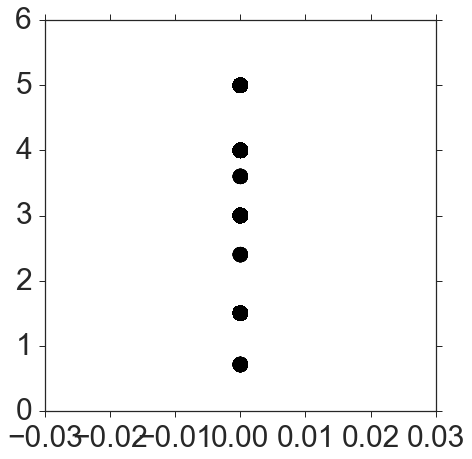

In [12]:
fig, axScatter = plt.subplots(figsize=(7, 7))
#axScatter.scatter(x, y, s=ycount*0.1, c=colors['MTeal'], alpha=0.5, linewidths=0.1, marker='o', label='Ground Truth')
axScatter.scatter(x, y, s=ycount*0.1, c='k', alpha=0.5, linewidths=0.1, marker='o', label='Ground Truth')
# commenting out diff algs; can do diff plots
axScatter.scatter(burn_knn, enr_knn, s=ycount*0.1, c=colors['MBrwn'], alpha=0.5, linewidths=0.1, marker='s', label='kNN Pred')
#axScatter.scatter(burn_rr, enr_rr, s=ycount*0.1, c=colors['MPurp'], alpha=0.5, linewidths=0.1, marker='s', label='Ridge Pred')
#axScatter.scatter(burn_svr, enr_svr, s=ycount*0.1, c=colors['MTeal'], alpha=0.5, linewidths=0.1, marker='s', label='SVR Pred')
#axScatter.legend()
plt.xlabel('Burnup [GWd/MTU]', fontsize=16)
plt.ylabel('Enrichment [%U235]', fontsize=16)
# comment out to see the really bad predictions
#plt.ylim(ymax=6)
fig.savefig('test.png', bbox_inches='tight')
plt.show()

NameError: name 'burn_svr' is not defined

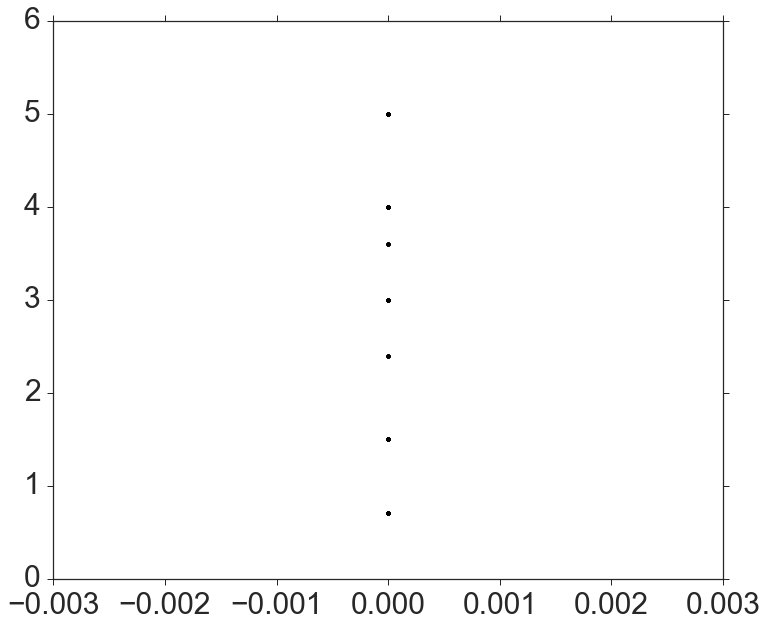

In [32]:
plt.clf()
fig, axScatter = plt.subplots(figsize=(12,10))
#fig.suptitle('test title', fontsize=20)
axScatter.scatter(x, y, c='k', s=10, linewidths=0.1, marker='o', label='Ground Truth')
#axScatter.scatter(burn_knn, enr_knn, c=colors['MBrwn'], s=10, linewidths=0.1, marker='s', label='kNN Pred')
#axScatter.scatter(burn_rr, enr_rr, c=colors['MPurp'], s=10, linewidths=0.1, marker='s', label='Ridge Pred')
axScatter.scatter(burn_svr, enr_svr, c=colors['MTeal'], s=10, linewidths=0.1, marker='s', label='SVR Pred')
axScatter.legend()
plt.xlabel('Burnup [GWd/MTU]', fontsize=16)
plt.ylabel('Enrichment [%U235]', fontsize=16)
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1, pad=0.2, sharex=axScatter)
axHisty = divider.append_axes("right", 1.75, pad=0.2, sharey=axScatter)
axHistx.hist(x, bins=xbins, color='0.5')
axHisty.hist(y, bins=ybins, orientation='horizontal', color='0.5')
plt.setp(axHistx.get_xticklabels(), visible=False)
plt.setp(axHisty.get_yticklabels(), visible=False)
axHistx.set_yticks([0, 250, 500])
axHisty.set_xticks([0, 1000, 2000])
# comment out to see the really bad predictions
#plt.ylim(ymax=6)
plt.show()